# YOUR PROJECT TITLE

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
from sympy import Symbol
from sympy.solvers import solve
sm.init_printing(use_unicode=True) # for pretty printing
from IPython.display import display
import matplotlib.pyplot as plt # baseline modul
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject


# The Solow model with human capital

We will be working with a solowmodel with fysical and human capital. 
Like fysical capital in the standard solow model, human capital accumulates. A fixed rate depriciates each priode, and a constant fraction $s_H$ of production is turned in to human capital. human capital can be thought of as things such as education, health and IQ.  


## Variables 

* $Y_t$  : Production
* $L_t$ : Labor
* $A_t$ : Technology
* $K_t$ : Phisical Capital
* $H_t$ : Human Capital

## Parameters

* $s_h$:       Savings/Investments in human capital\
* $s_k$:       Savings/Investments in physical capital\
* $g$:         Growth rate of technology\
* $n$:         Growth rate of labour force
* $\delta$:     Deprisiation rate of physical capital\
* $\alpha$:     Return physical capital\
* $\phi$:       Return on human capital\
* $h$:         Human capital per effective worker (Stock)\

## Equations 

**Production funciton** 

$ Y_{t}=K_{t}^{\alpha}H_{t}^{\varphi}(A_{t}L_{t})^{1-\alpha-\varphi} $

**Saving** \
Constant fraction of production in the eoconomy

$ S_t = (s_H+s_K)Y_t,\, s_H+s_K\in(0,1) $

**Capital Accumulation**

$ K_{t+1}=s_{K}Y_t+(1-\delta)K_{t}$

**Human capital accumulation** 

$ H_{t+1} = s_{H}Y_t+(1-\delta)H_t $

**Population and teknology (TFP) growth**

$ L_{t+1} = (1+n)L_t $

$ A_{t+1} = (1+g)A_t $

## Tilde equations

In order to analyse the model we calculate the per effectiv worker values. That is, divid by the population and teknology level. 


**Defitiontions**

Production, fysical capital and human capital as divided by popluation and teknology to get .... \
$   \tilde{y}_{t} = \frac{Y_{t}} {A_tL_t} $\
$   \tilde{k}_{t} = \frac{K_{t}} {A_tL_t} $\
$   \tilde{h}_{t} = \frac{H_{t}} {A_tL_t} $

**Transition Equations** 

The tilde transition eqautions can be found by inserting the tilde definitions ...

$ \tilde{k}_{t+1}= \frac{1}{(1+n)(1+g)}[s_K\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+(1-\delta)\tilde{k}_{t}] $

$ \tilde{h}_{t+1}= \frac{1}{(1+n)(1+g)}[s_H\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+(1-\delta)\tilde{h}_{t}] $



**OBS: In the folowing, the tilde values will simply be writen as uncapitalized letters**



## Analytical solution

## Nulclines

1. Defining the variables as symbols for using sympy

In [2]:

k = sm.symbols('k')
h = sm.symbols('h')
y = sm.symbols('y')
c = sm.symbols('c')
sh = sm.symbols('s_h')
sk = sm.symbols('s_k')
delta = sm.symbols('delta')
phi = sm.symbols('phi')
alpha = sm.symbols('alpha')
g = sm.symbols('g')
n = sm.symbols('n')
A = sm.symbols('A')

x = [sk, sh, g, phi, n, alpha, delta]


2. Function for deriving the analytical solution

In [3]:
# Analitical soluction - findes the solow equations and return the nult line 
def analytical(x, latex = False):

    """ Derives the equations for the nultlines based on the transition equations for human and fysical capital

    Args: 
    x:  list of parameters

    Returns:
    Nullclines for physical and human capital h(k)
    if latex = true, printes the latex code for the nulclines

    """

    #Transition lines:
    k_t2 = (sk*k**alpha*h**phi+(1-delta)*k)/((1+n)*(1+g))
    h_t2 = (sh*k**alpha*h**phi+(1-delta)*h)/((1+n)*(1+g))

    #Change in capital stock () - Sollow equations 
    delta_k = k_t2 - k 
    delta_h = h_t2 - h
    delta_combined = delta_h + delta_k

    #Nultlines (Stock of capital is constant)
    sollow_k = sm.Eq(delta_k,0)
    sollow_h = sm.Eq(delta_h,0)

    #Isolating k, and h in each equation - For drawing the phase diagram h should be isolated in both
    nult_k = sm.solve(sollow_k,h)
    nult_h = sm.solve(sollow_h,h)

    out = {}
    out['sollow_k'] = sollow_k
    out['sollow_h'] = sollow_h

    out['nult_k'] = nult_k
    out['nult_h'] = nult_h

    if latex == True: 

        print(f'  Latex code for the nult line for physical capital: \n {sm.latex(nult_k)} \n\n')
        print(f'  Latex code for the nult line for human capital: \n  {sm.latex(nult_h)}')


    return out
#    return nult_k, nult_h
#    return h_nult_vek, k_nult_vek


3. Calling function which derivaes the nulclines and prints latex code 

In [4]:
out = analytical(x, True)

  Latex code for the nult line for physical capital: 
 \left[ \left(\frac{k^{1 - \alpha} \left(\delta + g n + g + n\right)}{s_{k}}\right)^{\frac{1}{\phi}}\right] 


  Latex code for the nult line for human capital: 
  \left[ \left(\frac{k^{- \alpha} \left(\delta + g n + g + n\right)}{s_{h}}\right)^{\frac{1}{\phi - 1}}\right]



Nulcline for pysical capital:

$$ \tilde{h_t} = \left[ \left(\frac{k^{1 - \alpha} \left(\delta + g n + g + n\right)}{s_{k}}\right)^{\frac{1}{\phi}}\right], \quad \Delta \tilde{k}_t = 0 $$



Nulcline for human capital:

$$ \tilde{h_t} =\left[ \left(\frac{k^{- \alpha} \left(\delta + g n + g + n\right)}{s_{h}}\right)^{\frac{1}{\phi - 1}}\right], \quad \Delta \tilde{h}_t = 0$$

## Steady state human and physical capital 

Solving for steady state gives the folowing levels of fysical and human capital:

Steady state pysical capital:
$$\tilde{k}^{\ast}=\left(\dfrac{s_K^{1-\varphi}s_H^{\varphi}}{n+g+\delta+ng}\right)^{\frac{1}{1-\alpha-\varphi}}$$


Steady state human capital:
$$\tilde{h}^{\ast}=\left(\dfrac{s_K^{\alpha}s_H^{1-\alpha}}{n+g+\delta+ng}\right)^{\frac{1}{1-\alpha-\varphi}}$$


There are cross-effects, meaning that an increase in the savings rate for physical capital incrseas both the level of human and fysical capital. The same is true for the savings on human capital 

## Numerical solution

We now progress to the numerical solution to the Solow-Swan-model with human capital accumulation


In [5]:
#For our numerical solution we use the following baseline parameters

s_h = 0.1
s_k = 0.1
g = 0.02
n = 0.01
alpha = 1/3
phi = 1/3
delta = 0.06

In [6]:
#For our numerical solution

def f(h,k,s_h,s_k,g,n,alpha,phi,delta):
    """input arguments:
    h     (float): Human capital per effective worker (Stock)
    k     (float): Physical capital per effective worker (Stock)
    s_h   (float): Savings/Investments in human capital
    s_k   (float): Savings/Investments in physical capital
    g     (float): Growth rate of technology
    n     (float): Growth rate of labour force
    delta (float): Depreciation rate of physical capital
    alpha (float): Return on physical capital
    phi   (float): Return on human capital
    
    Returns: 
    The transition equation for human and physical capital per effective worker in steady state
    """

    h_function = 1/((1+n)*(1+g))*(s_h*k**(alpha)*h**(phi)+(1-delta)*h)-h
    k_function = 1/((1+n)*(1+g))*(s_k*k**(alpha)*h**(phi)+(1-delta)*k)-k
    return h_function,k_function

# Setting up the objective and solving the model
objective = lambda x: [f(x[0],x[1],s_h,s_k,g,n,alpha,phi,delta)]
solution = optimize.root(objective,[1,1],method = 'broyden1')
num_solution = solution.x

print(f'The level of human and physical capital per effective worker in steady state is = {num_solution[0]:.3f} and {num_solution[1]:.3f}, respectively.')


The level of human and physical capital per effective worker in steady state is = 1.363 and 1.363, respectively.


The phase-diagram can be used to illustrate that there only exist a single point where both human and physical capital per effective worker is constant, which is characterized as our steady state:

$\Delta\tilde{h}^{\ast}=\Delta\tilde{k}^{\ast}=0$ 


The phase-diagram consists of two nullclines where $\Delta\tilde{h}^{\ast}=0$ and $\Delta\tilde{k}^{\ast}=0$, repsectively.

Text(0.5, 1.0, 'Phase diagram')

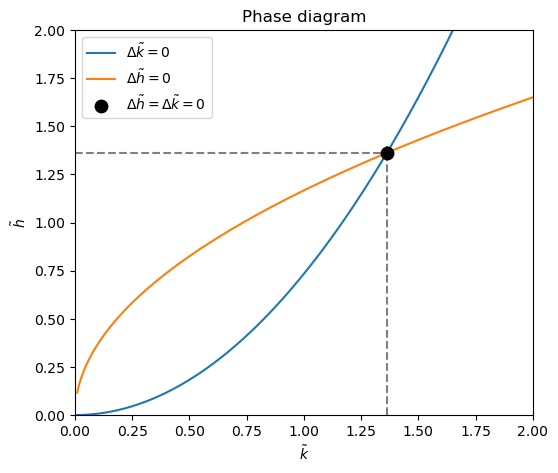

In [7]:
# Define a function to calculate the nullclines
def solve_ss(s_h, s_k, g, n, alpha, phi, delta):
    """args:
    s_h    (float): Savings/Investments in human capital
    s_k    (float): Savings/Investments in physical capital
    g      (float): Growth rate of technology
    n      (float): Growth rate of labour force
    alpha  (float): Return on physical capital
    phi    (float): Return on human capital
    delta  (float): Depreciation rate
    
    Returns:
    Nullclines for physical and human capital
    """
    # Grid for physical capital
    k_vec = np.linspace(0.01, 3, 500)

    # Grid for human capital when delta_k = 0
    h_vec_DeltaK0 = np.empty(500)

    # Grid for human capital when delta_h = 0
    h_vec_DeltaH0 = np.empty(500)

    for i, k in enumerate(k_vec):
        # Solve for delta_h = 0
        obj = lambda h: f(h, k, s_h, s_k, g, n, alpha, phi, delta)[0]
        result = optimize.root_scalar(obj, method='brentq', bracket=[1e-20, 50])
        h_vec_DeltaH0[i] = result.root

        # Solve for delta_k = 0
        obj = lambda h: f(h, k, s_h, s_k, g, n, alpha, phi, delta)[1]
        result = optimize.root_scalar(obj, method='brentq', bracket=[1e-20, 50])
        h_vec_DeltaK0[i] = result.root

    return k_vec, h_vec_DeltaK0, h_vec_DeltaH0

# Call the solve_ss function to calculate nullclines
k_vec, h_vec_DeltaK0, h_vec_DeltaH0 = solve_ss(s_h, s_k, g, n, alpha, phi, delta)

# Create the plot
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(1,2,1)
ax.plot(k_vec, h_vec_DeltaK0, label=r'$\Delta \tilde{k}=0$')
ax.plot(k_vec, h_vec_DeltaH0, label=r'$\Delta \tilde{h}=0$')
ax.set_xlabel(r'$\tilde{k}$')
ax.set_ylabel(r'$\tilde{h}$')


#Marking the steady state points
ax.scatter(num_solution[1],num_solution[0],color='black',s=80,zorder=2.5, label=r'$\Delta\tilde{h}=\Delta\tilde{k}=0$')
ax.legend() 

# Draw lines to mark ss-value on the axes
plt.axvline(num_solution[1], ymax=0.7, color='gray', linestyle='--') 
plt.axhline(num_solution[0], xmax=0.7, color='gray', linestyle='--') 


# Set the axis limits
ax.set(xlim=(0, 2), ylim=(0, 2))

ax.set_title('Phase diagram')

# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

# Conclusion

Add concise conclusion. 